In [1]:
from USTs import USTs
from DataFetcher import DataFetcher
import datetime
from scipy.optimize import newton
import pandas as pd
import requests
from bs4 import BeautifulSoup
import requests
from dateutil.relativedelta import relativedelta
from Curves import ParCurves
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CUSIPs = ['912810RB6', '912810SR0']
START = datetime.date(2025, 6, 1)
END = datetime.date(2025, 7, 7)
# USTs(None, None).get_cusip_timeseries(cusips, datetime.date(2025, 1, 1), datetime.date(2025, 6, 30))

In [3]:
usts = USTs(date=datetime.date(2025, 7, 7))
ust_set = usts.get_current_UST_set(settlement_date=datetime.datetime(2025, 7, 1),
                                   get_ytms=True,
                                   include_FRNs=False,
                                   include_TIPS=False,
                                   include_outstanding=False)

In [4]:
screening_df = usts.get_initial_screening_set()
screening_df

,Duration exposure,Current spread,Par curve spread,Long bond,Tenor,YTM,Short bond,Tenor,YTM
0,Long duration,10.7 bps,0.4 bps,2.875% May-43,30-Year,4.956772,1.125% May-40,20-Year,4.849721
1,Long duration,17.0 bps,6.7 bps,4.750% Feb-41,30-Year,4.793211,3.500% Feb-39,30-Year,4.623071
2,Long duration,17.3 bps,9.4 bps,4.250% Nov-40,30-Year,4.795844,3.500% Feb-39,30-Year,4.623071
3,Long duration,12.9 bps,5.2 bps,4.375% May-40,30-Year,4.752344,3.500% Feb-39,30-Year,4.623071
4,Long duration,19.7 bps,12.7 bps,4.375% May-41,30-Year,4.820162,3.500% Feb-39,30-Year,4.623071


In [13]:
usts._get_cusip_from_label('1.125% May-40')

'912810SR0'

In [14]:
ust_set.loc[['912810SR0']]

,Security type,Rate,Maturity date,End of day,Security term,Issue date,Years to maturity,UST label,EOD YTM,Duration,Rank
Cusip,,,,,,,,,,,
912810SR0,Bond,1.125,2040-05-15,60.875,20-Year,2020-06-01,14.884932,1.125% May-40,4.849721,12.954924,21


In [9]:
ust_set.loc['912810SR0']

Security type                       Bond
Rate                               1.125
Maturity date        2040-05-15 00:00:00
End of day                        60.875
Security term                    20-Year
Issue date           2020-06-01 00:00:00
Years to maturity              14.884932
UST label                  1.125% May-40
EOD YTM                         4.849721
Duration                       12.954924
Rank                                  21
Name: 912810SR0, dtype: object

['912810RB6', '912810SR0'] Duration exposure    Long duration
Current spread            10.7 bps
Par curve spread           0.4 bps
Long bond            2.875% May-43
Tenor                      30-Year
YTM                       4.956772
Short bond           1.125% May-40
Tenor                      20-Year
YTM                       4.849721
Duration long            13.012482
Duration short           12.954924
Name: 0, dtype: object


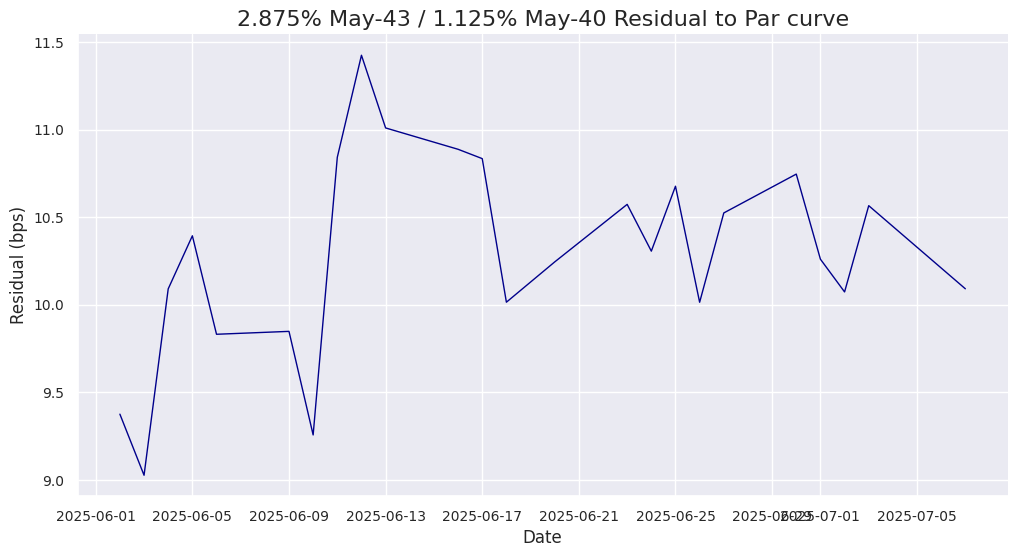

['912810QN1', '912810QA9'] Duration exposure    Long duration
Current spread            17.0 bps
Par curve spread           6.7 bps
Long bond            4.750% Feb-41
Tenor                      30-Year
YTM                       4.793211
Short bond           3.500% Feb-39
Tenor                      30-Year
YTM                       4.623071
Duration long            10.742123
Duration short           10.361194
Name: 1, dtype: object


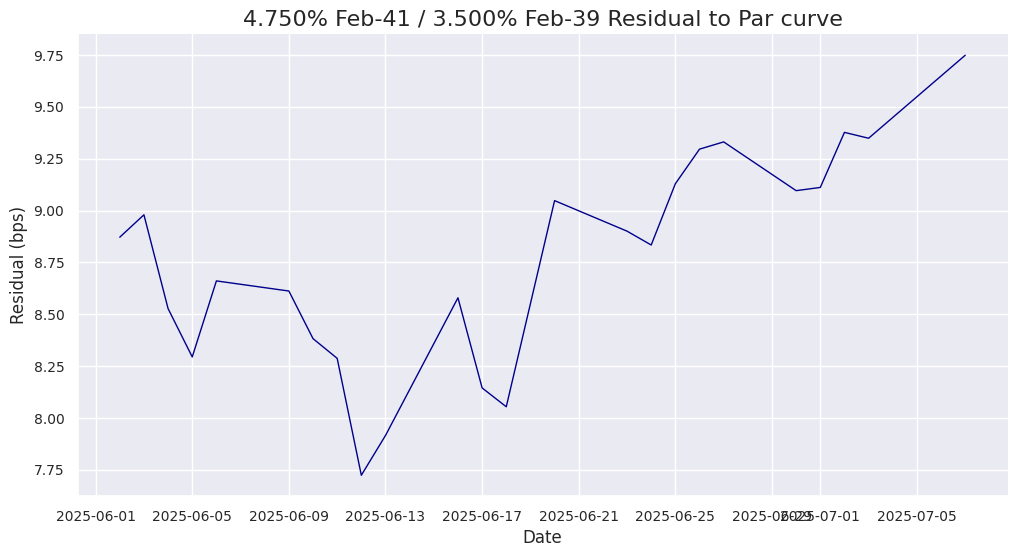

['912810QL5', '912810QA9'] Duration exposure    Long duration
Current spread            17.3 bps
Par curve spread           9.4 bps
Long bond            4.250% Nov-40
Tenor                      30-Year
YTM                       4.795844
Short bond           3.500% Feb-39
Tenor                      30-Year
YTM                       4.623071
Duration long            10.968877
Duration short           10.361194
Name: 2, dtype: object


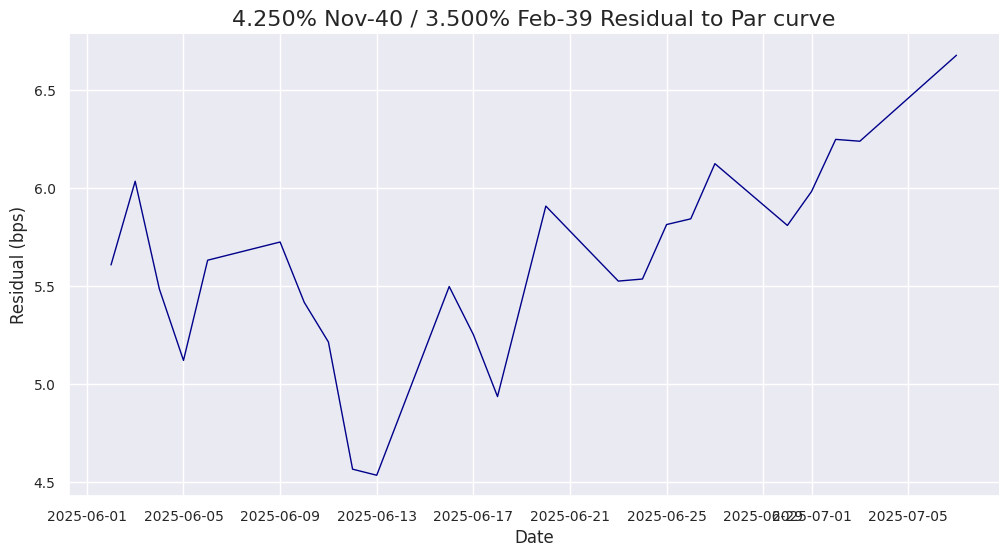

['912810QH4', '912810QA9'] Duration exposure    Long duration
Current spread            12.9 bps
Par curve spread           5.2 bps
Long bond            4.375% May-40
Tenor                      30-Year
YTM                       4.752344
Short bond           3.500% Feb-39
Tenor                      30-Year
YTM                       4.623071
Duration long            10.673678
Duration short           10.361194
Name: 3, dtype: object


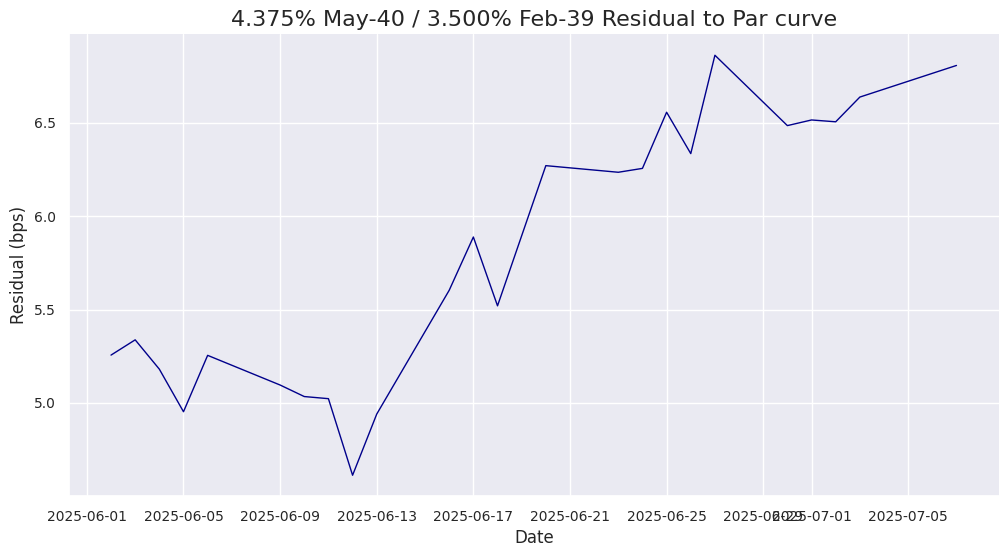

['912810QQ4', '912810QA9'] Duration exposure    Long duration
Current spread            19.7 bps
Par curve spread          12.7 bps
Long bond            4.375% May-41
Tenor                      30-Year
YTM                       4.820162
Short bond           3.500% Feb-39
Tenor                      30-Year
YTM                       4.623071
Duration long            11.140169
Duration short           10.361194
Name: 4, dtype: object


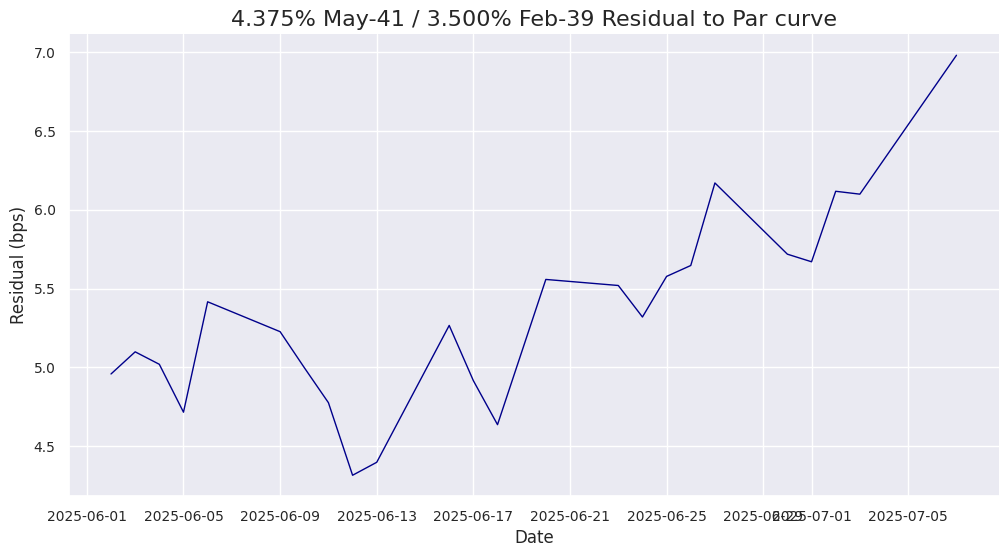

In [6]:
date_range = pd.date_range(START, END).to_list()
valid_dates = []
for date in date_range:
    if not (date.date().weekday() in [5, 6]) or (date.date() in usts.holidays):
        valid_dates.append(datetime.datetime(date.year, date.month, date.day))

auction_data = usts.auction_data
all_data = {}
for date in valid_dates:
    price_data = DataFetcher().fetch_historical_UST_data(date.date())
    if price_data is not None:
        price_data = price_data[price_data['Security type'] != 'Bill']
        settlement = usts.adjust_for_bad_day(date + relativedelta(days=1))
        full_date_data = usts.get_current_UST_set(settlement_date=settlement,
                                                auction_data=auction_data,
                                                price_data=price_data)
        all_data[date] = full_date_data

trade_set = usts.trade_screening_set
for i in range(len(trade_set)):
    trade_row = trade_set.iloc[i, :]
    cusips = [usts._get_cusip_from_label(trade_row['Long bond']), usts._get_cusip_from_label(trade_row['Short bond'])]
    print(cusips, trade_row)
    spread_df = pd.DataFrame(columns=['Long bond yield', 'Short bond yield', 'Spread', 'Par curve spread'])
    for key in all_data.keys():
        df = all_data[key]
        filtered_set = df[(df['Years to maturity'] > 90/365) & (df['Security type'] != 'Bill') & (df['Rank'] > 2)]
        bspline_model = ParCurves(filtered_set).Bspline_with_knots(knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 15, 20, 25],
                                                                   return_data=False)
        otr_set = df[df['Rank'] == 1]
        interpolator = scipy.interpolate.interp1d(
            x=otr_set['Duration'],
            y=otr_set['Years to maturity'],
            kind='cubic',
            fill_value='extrapolate')
        long_tenor, short_tenor = float(interpolator(trade_row['Duration long'])), float(interpolator(trade_row['Duration short']))
        par_spread = float(bspline_model(long_tenor) - bspline_model(short_tenor))
        long_yield = all_data[key].loc[cusips[0], 'EOD YTM']
        short_yield = all_data[key].loc[cusips[1], 'EOD YTM']
        long_duration, short_duration = trade_row['Duration long'], trade_row['Duration short']
        spread_df.loc[key] = [long_yield, short_yield, long_yield-short_yield, par_spread]
    spread_df['Par curve residual'] = (spread_df['Spread'] - spread_df['Par curve spread'])*100
    plt.figure(figsize=(12, 6))
    sns.set_theme(context='notebook', style='darkgrid')
    sns.lineplot(data=spread_df, x=spread_df.index, y='Par curve residual', color='darkblue', linewidth=1)
    sns.despine()
    plt.title(f"{trade_row['Long bond']} / {trade_row['Short bond']} Residual to Par curve", fontdict={'size': 16,
                                                                                                       'weight': 'normal',
                                                                                                       'family': 'sans-serif'})

    plt.ylabel("Residual (bps)", fontdict={'size':12})
    plt.xlabel('Date', fontdict={'size':12})
    plt.tick_params(axis='both', labelsize=10)
    plt.show()